In [1]:
using CUDAdrv; CUDAdrv.name(CuDevice(0))

"GeForce GTX 1070 Ti"

┌ Info: Precompiling ImageIO [82e4d734-157c-48bb-816b-45c225c6df19]
└ @ Base loading.jl:1260
┌ Info: Precompiling PNGFiles [f57f5aa1-a3ce-4bc8-8ab9-96f992907883]
└ @ Base loading.jl:1260
┌ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
└ @ Base loading.jl:1260


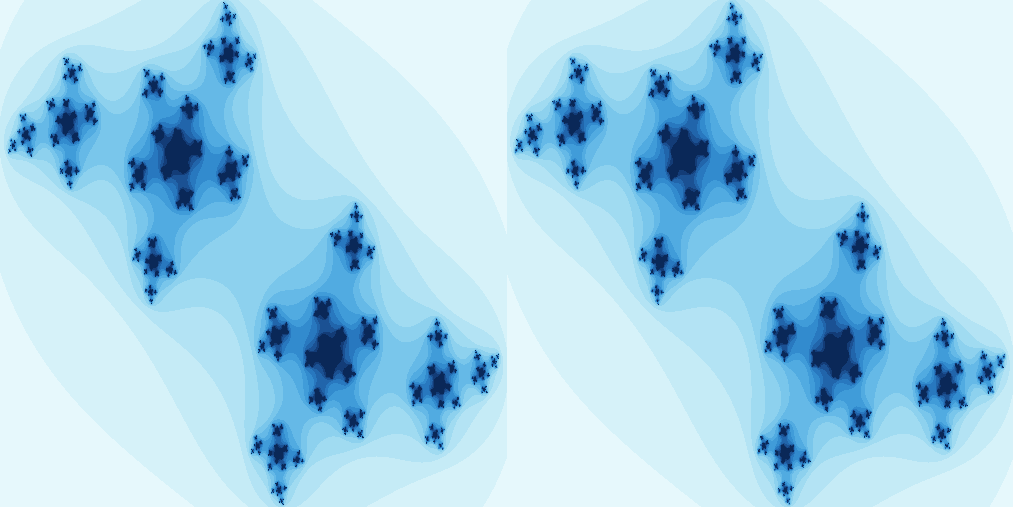

In [12]:
using CuArrays, FileIO, Colors, GPUArrays, BenchmarkTools, ImageShow
using CuArrays: CuArray
"""
The function calculating the Julia set
"""
function juliaset(z0, maxiter)
    c = ComplexF32(-0.5, 0.75)
    z = z0
    for i in 1:maxiter
        abs2(z) > 4f0 && return (i - 1) % UInt8
        z = z * z + c
    end
    return maxiter % UInt8 # % is used to convert without overflow check
end
range = 100:50:2^12
cutimes, jltimes = Float64[], Float64[]
function run_bench(in, out)
  # use dot syntax to apply `juliaset` to each elemt of q_converted 
  # and write the output to result
  out .= juliaset.(in, 16)
  # all calls to the GPU are scheduled asynchronous, 
  # so we need to synchronize
  GPUArrays.synchronize(out)
end
# store a reference to the last results for plotting
last_jl, last_cu = nothing, nothing
for N in range
  w, h = N, N
  q = [ComplexF32(r, i) for i=1:-(2.0/w):-1, r=-1.5:(3.0/h):1.5]
  for (times, Typ) in ((cutimes, CuArray), (jltimes, Array))
    # convert to Array or CuArray - moving the calculation to CPU/GPU
    q_converted = Typ(q)
    result = Typ(zeros(UInt8, size(q)))
    for i in 1:10 # 5 samples per size
      # benchmarking macro, all variables need to be prefixed with $
      t = Base.@elapsed begin
				run_bench(q_converted, result)
      end
      global last_jl, last_cu # we're in local scope
      if result isa CuArray
        last_cu = result
      else
      	last_jl = result
      end
      push!(times, t)
    end
  end
end

cu_jl = hcat(Array(last_cu), last_jl)
cmap = colormap("Blues", 16 + 1)
color_lookup(val, cmap) = cmap[val + 1]
color_lookup.(cu_jl, (cmap,))

In [11]:
import Pkg; Pkg.add("ImageIO")
import Pkg; Pkg.add("ImageMagick")

  Resolving package versions...
  Installed PNGFiles ─ v0.2.0
  Installed ImageIO ── v0.2.0
   Updating `C:\Users\amira\.julia\environments\v1.4\Project.toml`
  [82e4d734] + ImageIO v0.2.0
   Updating `C:\Users\amira\.julia\environments\v1.4\Manifest.toml`
  [82e4d734] + ImageIO v0.2.0
  [f57f5aa1] + PNGFiles v0.2.0
  Resolving package versions...
   Updating `C:\Users\amira\.julia\environments\v1.4\Project.toml`
  [6218d12a] + ImageMagick v0.7.5
   Updating `C:\Users\amira\.julia\environments\v1.4\Manifest.toml`
 [no changes]


In [1]:
using CUDA

┌ Info: Precompiling CUDA [052768ef-5323-5732-b1bb-66c8b64840ba]
└ @ Base loading.jl:1260


In [5]:
N=100
x_d = CUDA.fill(1.0f0, N)

100-element CuArray{Float32,1,Nothing}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

In [7]:
y_d = fill(2.0f0, N)

100-element Array{Float32,1}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 ⋮
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [10]:
y_d=CuArray(y_d)

100-element CuArray{Float32,1,Nothing}:
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 ⋮
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0
 2.0

In [12]:
1.0/y_d

1×100 LinearAlgebra.Transpose{Float64,CuArray{Float64,1,Nothing}}:
 0.005  0.005  0.005  0.005  0.005  …  0.005  0.005  0.005  0.005  0.005